
# Анализ бизнес-показателей. Проект.

## Описание проекта

Развлекательное приложение Procrastinate Pro+ закзазало маркетинговое исследование. Несмотря на огромные вложения в рекламу,
последние несколько месяцев компания терпит убытки. Задачаисследования — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
лог сервера с данными об их посещениях,
выгрузка их покупок за этот период,
рекламные расходы.

В ходе исследования нам предстоит изучить:
откуда приходят пользователи и какими устройствами они пользуются,
сколько стоит привлечение пользователей из различных рекламных каналов;
сколько денег приносит каждый клиент,
когда расходы на привлечение клиента окупаются,
какие факторы мешают привлечению клиентов.

## План выполнения работ

**Подготовка**
  
1.1 Импорт библиотек

1.2. Загрузка данных

1.3. Обзор данных

**Предобработка данных**

2.1 Обработка дубликатов, переименование столбцов, замена типов данных.

**Написание пользовательских функций**

3.1 Функция get_profiles

3.2 Функция для расчета LTV и ROI

3.3 Функция для расчета удержания

3.4 Функция для расчета конверсии

3.5 Функция для сглаживания фрейма

3.6 Функция для визуализации удержания

3.7 Функция для визуализации конверсии

3.8 Функция для визуализации LTV и ROI

**Исследовательский анализ**

4.1 Составление профилей пользователей

4.2 Изучение страны пользователей и распределение по долям

4.3 Основные устройства польщователей

4.4 Рекламные источники

**Маркетинг**

5.1 Общая сумма расходов

5.2 Динамика изменения расходов по времени

5.3 Оцека окупаемости рекламы

5.3.1 - 5.3.10 - Изучения влияния разных факторов на конверсию, удеражание, LTV и ROI

**Подведение итогов**


### 1.1 Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

### 1.2 Загрузка данных

In [17]:
visits, orders, costs = (
    pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/gcWAM1ts40UQeA'),  # журнал сессий
    pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/4Myt_4ataboufA'),  # покупки
    pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/JfYC5GFo42Hi0w'),  # траты на рекламу
)

### 1.3 Обзор даных

In [18]:
costs.sample()

,dt,Channel,costs
1338,2019-07-18,OppleCreativeMedia,11.0


In [19]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [20]:
visits.sample()

,User Id,Region,Device,Channel,Session Start,Session End
165405,496375895297,United States,Mac,FaceBoom,2019-09-29 16:42:53,2019-09-29 16:47:18


In [21]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [22]:
orders.sample()

,User Id,Event Dt,Revenue
16520,202074956918,2019-09-06 14:09:08,4.99


In [23]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


### Наблюдения:

В нашем распорядение 3 датасета:

* Датасет visits хранит лог сервера с информацией о посещениях сайта. У нас есть информация об id пользователя,
Region — страна пользователя, device — тип устройства пользователя, Channel — идентификатор источника перехода,
Session Start — дата и время начала сессии, Session End — дата и время окончания сессии. Всего 309901 строк, пропуски отсутсвуют

* Датасет orders хранит информацию озаказах. User Id — уникальный идентификатор пользователя, Event Dt — дата и время покупки, Revenue — сумма заказа. Всего 40212 строк, пропуски отсутсвуют

* Датасет costs — информация о расходах на рекламу. Всего 1800 строк. Пропуски отсутсвуют.

## Предобработка данных

In [24]:
for df in [visits, orders, costs]:
  print(df.duplicated().sum())

0
0
0


In [25]:
costs = costs.rename(columns={'Channel': 'channel'})
orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue' })
visits = (visits.rename(columns={'User Id': 'user_id',
                                 'Region':'region',
                                 'Device':'device',
                                 'Channel':'channel',
                                 'Session Start': 'session_start',
                                 'Session End': 'session_end' }))

In [26]:
visits.sample()

,user_id,region,device,channel,session_start,session_end
224726,574814163105,France,Android,LeapBob,2019-06-04 01:22:18,2019-06-04 01:37:17


In [27]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

###  Результаты предобработки данных:

В результате предобработки мы не обнаружили дубликатов ни в одном из датасетов

Были переименованы названия некоторым столбцов для придания единообразия

Мы также преобразовали значения колонок, указывающих на время в формат времени

## Пользовательские функции

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Фукция get_profiles

In [28]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### Функция для расчёта LTV и ROI get_ltv

In [29]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )


#### Функция для расчета удержания get_retention

In [30]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция для расчёта конверсии get_conversion

In [31]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция для сглаживания фрейма filter_data

In [32]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

#### Функция для визуализации удержания plot_retention

In [33]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    plt.tight_layout()
    plt.show()

#### Функция для визуализации конверсии

In [62]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Функция для визуализации LTV и ROI

In [34]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [35]:
events = None

In [36]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

In [37]:
allusers = get_profiles(visits, orders, events, costs)

## Исследовательский анализ данных



### 4.1 Составим профили пользователей.
Определим минимальную и максимальную даты привлечения пользователей.

In [ ]:
allusers.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [38]:
print(f"Минимальная дата привлечения клиентов -  {allusers['dt'].min()} ")
print(f"Максимальная дата привлечения клиентов -  {allusers['dt'].max()} ")

Минимальная дата привлечения клиентов -  2019-05-01 
Максимальная дата привлечения клиентов -  2019-10-27 


 ### 4.2 Страны пользователей и их распределение по долям. Процент оплативших по каждому региону


In [39]:
def create_table(df, parameter):
    df1 = (df.groupby(parameter)
             .agg({'user_id': 'nunique'})
             .reset_index()
             .rename(columns={'user_id': 'users_number'}))
    df1['total_users'] = df1['users_number'].sum()
    df1['share in %'] = df1['users_number']/df1['total_users']*100
    df1 = df1.sort_values(by = 'share in %', ascending = False)
    return df1

In [40]:
def create_table1(df, parameter):
    df2 = create_table(df, parameter)
    df3 = create_table(df.query('payer == True'), parameter)
    df4 = df3.merge(df2, on = parameter,  how='left' )
    df4['share_within_parameter'] = df4['users_number_x']/df4['users_number_y']*100
    df4.columns = ['параметр', 'платящих клиентов по параметру', 'всего платящих клиентов', 'доля среди платящих в %', 'посетителей по параметру', 'всего посетителей', 'доля в % среди всех посетителей', 'доля оплативших по параметру в %']
    df5 = df4[['параметр','доля в % среди всех посетителей']].sort_values(by = 'доля в % среди всех посетителей', ascending= False)
    df6 = df4[['параметр','доля среди платящих в %']].sort_values(by = 'доля среди платящих в %', ascending= False)
    df7 = df4[['параметр','доля оплативших по параметру в %']].sort_values(by = 'доля оплативших по параметру в %', ascending= False)
    return df4, df5, df6, df7

Пользователтская функия для подсчета долей по параметру

In [41]:
def share_bar(df1, df2, df3, parameter, xlab, title1, title2, title3):
    plt.figure(figsize=(15, 5))
    ax=plt.subplot(1, 3, 1)
    sns.barplot(data=df1, x=parameter, y='доля в % среди всех посетителей', color='blue')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)
    plt.xlabel(xlab)
    plt.title(title1)
    ax = plt.subplot(1, 3, 2)
    sns.barplot(data=df2, x=parameter, y='доля среди платящих в %',  color='yellow')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)
    plt.xlabel(xlab)
    plt.title(title2)
    ax = plt.subplot(1, 3, 3)
    sns.barplot(data=df3, x=parameter, y='доля оплативших по параметру в %', color='green')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)
    plt.xlabel(xlab)
    plt.title(title3)
    plt.show()

Пользовательская функия для визуализации таблицы с распределением долей по параметру

In [44]:
reg, reg_t, reg_p, reg_s = create_table1(allusers, 'region')
reg

,параметр,платящих клиентов по параметру,всего платящих клиентов,доля среди платящих в %,посетителей по параметру,всего посетителей,доля в % среди всех посетителей,доля оплативших по параметру в %
0,United States,6902,8881,77.716473,100002,150008,66.664445,6.901862
1,UK,700,8881,7.881995,17575,150008,11.716042,3.982930
2,France,663,8881,7.465376,17450,150008,11.632713,3.799427
3,Germany,616,8881,6.936156,14981,150008,9.986801,4.111875


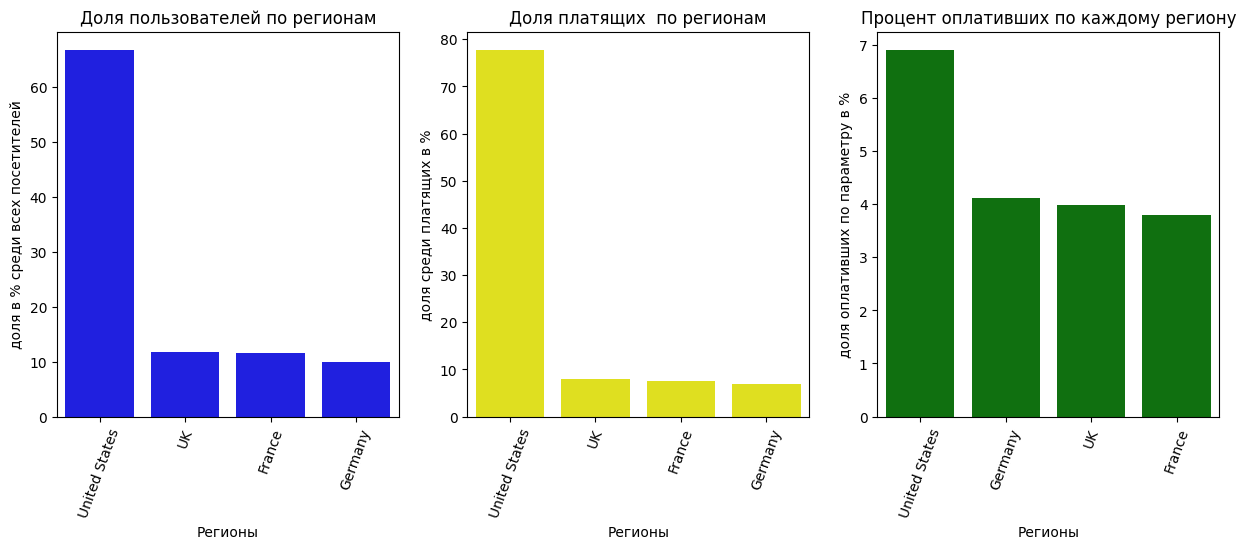

In [43]:
share_bar(reg_t, reg_p, reg_s, 'параметр', 'Регионы', 'Доля пользователей по регионам', 'Доля платящих  по регионам', 'Процент оплативших по каждому региону')

Мы видим, что примерно 67% всех пользователей приходят из США
При этом из всех платящих пользователей также больше всего клиентов из США. Доля США среди платящих пользователей - 78%. Мы также наблюдаем, что пользователи из США чаще становятся платящими клиентами. Так, практически 7% всех посетителей из США начинают пользоваться платными услугами. Для сравнения, посетители из Великобоитании, Франции и Герммании пользуются платными услугами  только в 4 % случаев

 ### 4.3  Основные устройства у всех клиентов и у платящих клиентов. Долю платящих для каждого устройства.

In [45]:
dev, dev_t, dev_p, dev_s = create_table1(allusers, 'device')
dev

,параметр,платящих клиентов по параметру,всего платящих клиентов,доля среди платящих в %,посетителей по параметру,всего посетителей,доля в % среди всех посетителей,доля оплативших по параметру в %
0,iPhone,3382,8881,38.081297,54479,150008,36.317396,6.207897
1,Android,2050,8881,23.082986,35032,150008,23.353421,5.851793
2,Mac,1912,8881,21.529107,30042,150008,20.026932,6.364423
3,PC,1537,8881,17.306610,30455,150008,20.302251,5.046790


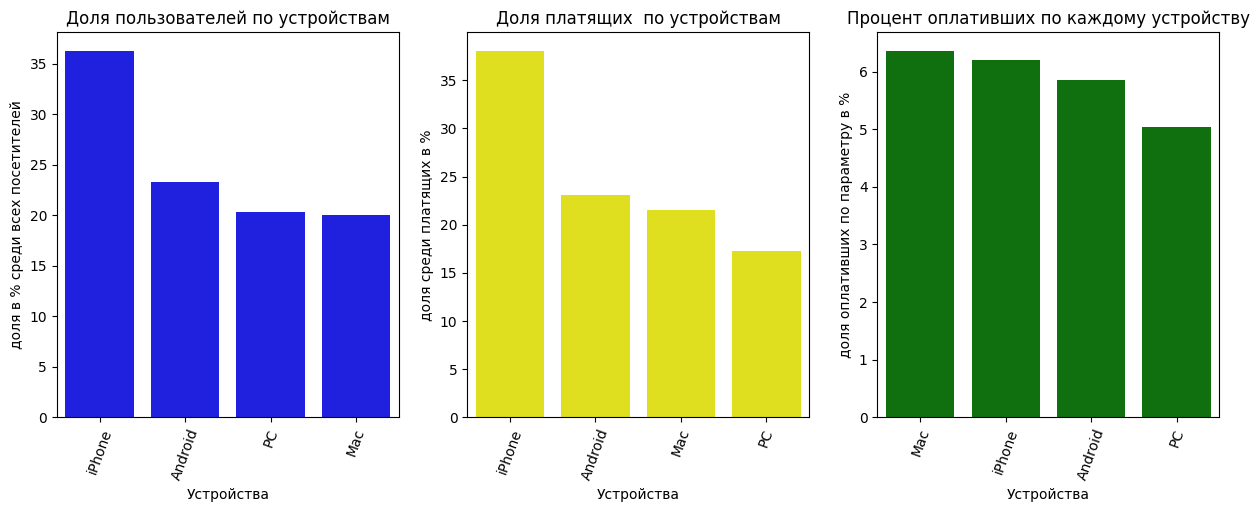

In [46]:
share_bar(dev_t, dev_p, dev_s, 'параметр', 'Устройства', 'Доля пользователей по устройствам', 'Доля платящих  по устройствам', 'Процент оплативших по каждому устройству')

Самые популярные устройства, как среди всех посетителей, так и среди платящих - это iPhone. Их доля составляет 36 % среди всех пользователей, и 38% среди платящих клиентов.
Можно также наблюдать, что пользователи PC чаще, чем другие остаются на бесплатных тарифах

### 4.4 Рекламные источники. Каналы, из которых пришло больше всего платящих пользователей.


In [47]:
chan, chan_t, chan_p, chan_s = create_table1(allusers, 'channel')
chan

,параметр,платящих клиентов по параметру,всего платящих клиентов,доля среди платящих в %,посетителей по параметру,всего посетителей,доля в % среди всех посетителей,доля оплативших по параметру в %
0,FaceBoom,3557,8881,40.051796,29144,150008,19.428297,12.204914
1,TipTop,1878,8881,21.146267,19561,150008,13.039971,9.600736
2,organic,1160,8881,13.061592,56439,150008,37.623993,2.055316
3,WahooNetBanner,453,8881,5.100777,8553,150008,5.701696,5.296387
4,AdNonSense,440,8881,4.954397,3880,150008,2.586529,11.340206
5,RocketSuperAds,352,8881,3.963518,4448,150008,2.965175,7.913669
6,LeapBob,262,8881,2.950118,8553,150008,5.701696,3.063253
7,OppleCreativeMedia,233,8881,2.623578,8605,150008,5.736361,2.707728
8,lambdaMediaAds,225,8881,2.533498,2149,150008,1.432590,10.469986
9,YRabbit,165,8881,1.857899,4312,150008,2.874513,3.826531


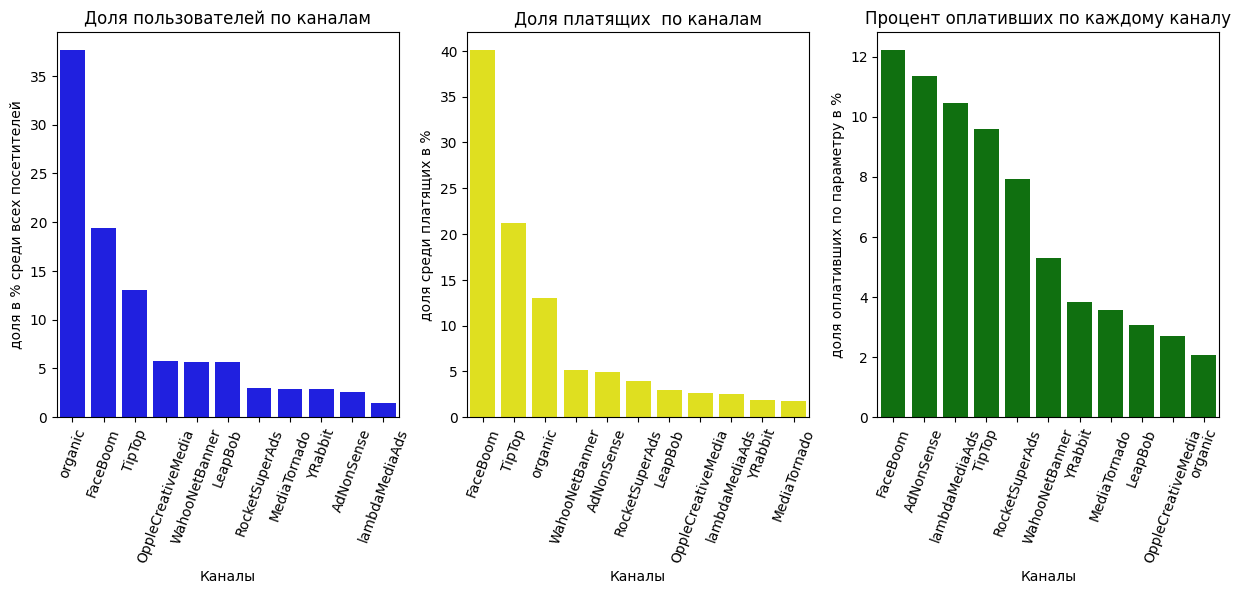

In [48]:
share_bar(chan_t, chan_p, chan_s,'параметр', 'Каналы', 'Доля пользователей по каналам', 'Доля платящих  по каналам', 'Процент оплативших по каждому каналу')


Больше всего посетителей приходят беспатно. Их доля примерно 38 % среди всех посетителей приложения. Однако, большинство таких клиентов не покупают платные услуги.
Каналы FaceBoom и TipTop привлекают больше всего как платных,так и бесплатных пользоваьелей приложения.
Стоит также обратить внимание на каналы AdNonSense	и lambdaMediaAds. Доля платных клиентов среди посетителей, пришедьших по этим каналам, составляет 11 % и 10 % сответственно.

## Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

### 5.1 Найдем общую сумму расходов на маркетинг и распределение расходов между каналами

In [49]:
print(f"Общие расходы на маркетинг составляют {costs['costs'].sum()} ")

Общие расходы на маркетинг составляют 105497.30000000002 


In [50]:
costs.groupby('channel').agg({'costs':'sum'}).reset_index().sort_values(by ='costs', ascending = False)

,channel,costs
6,TipTop,54751.30
1,FaceBoom,32445.60
7,WahooNetBanner,5151.00
0,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
2,LeapBob,1797.60
9,lambdaMediaAds,1557.60
3,MediaTornado,954.48
8,YRabbit,944.22


По количеству потраченных средств с большим отрывом лидируют каналы TipTop и FaceBoom

### 5.2 Динамика изменения расходов во времени (по неделям и месяцам) по каждому источнику.

In [51]:
costs1 = costs
costs1['month'] = costs1['dt'].astype('datetime64[M]')
costs1['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
cost_chan = costs1.groupby(['month','week','channel']).agg({'costs':'sum'}).reset_index()
cost_chan1 = costs1.groupby(['week','channel']).agg({'costs':'sum'}).reset_index()
cost_chan1

,week,channel,costs
0,18,AdNonSense,211.05
1,18,FaceBoom,535.70
2,18,LeapBob,16.80
3,18,MediaTornado,38.64
4,18,OppleCreativeMedia,24.00
...,...,...,...
255,43,RocketSuperAds,50.70
256,43,TipTop,3265.50
257,43,WahooNetBanner,253.20
258,43,YRabbit,48.33


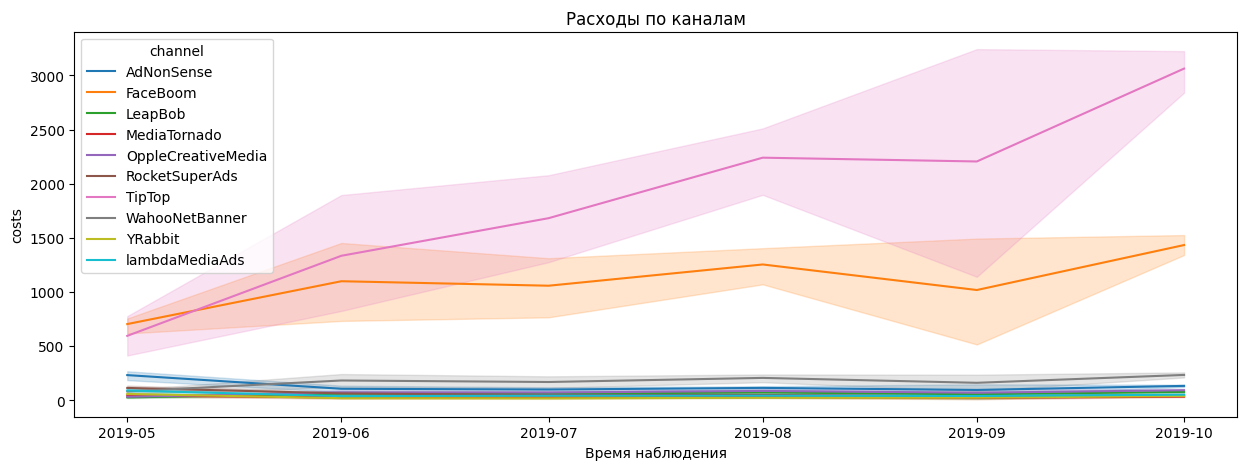

In [54]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=cost_chan, x='month', y='costs', hue='channel')
plt.xlabel('Время наблюдения')
plt.title('Расходы по каналам')
plt.show()

Большинство каналов расходуют примерно одинаковые бюджеты на всем промежутке наблюдения.
Начиная с середины мая мы видим резкий рост вложений в канал Tip Tip.
Канал FaceBoom на втором месте по расходам, однако расходы на этом канале не сильно менялись с июня по октябрь

In [56]:
allusers.groupby('channel').agg({'acquisition_cost':'mean'}).reset_index().sort_values(by = 'acquisition_cost', ascending = False)

,channel,acquisition_cost
6,TipTop,2.799003
1,FaceBoom,1.113286
0,AdNonSense,1.008054
9,lambdaMediaAds,0.724802
7,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
4,OppleCreativeMedia,0.250000
8,YRabbit,0.218975
3,MediaTornado,0.218717
2,LeapBob,0.210172


Канал Tip-Top значительно более дорогой, по сравнению со всеми остальными. Стоимость привлечения клиента в 2,5 раза дороже, чем у канала FaceBoom.

### 5.3 Оценим окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Будем считать, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.


- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

В данном разделе мы оцениваем эффективность рекламы, так что в дальнейшем мы будем анализировать данные без клиентов, поступивших из органического траффика

In [57]:
users = allusers.query('channel != "organic"')

#### 5.3.1 Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI

In [60]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    users, orders, observation_date, horizon_days
)

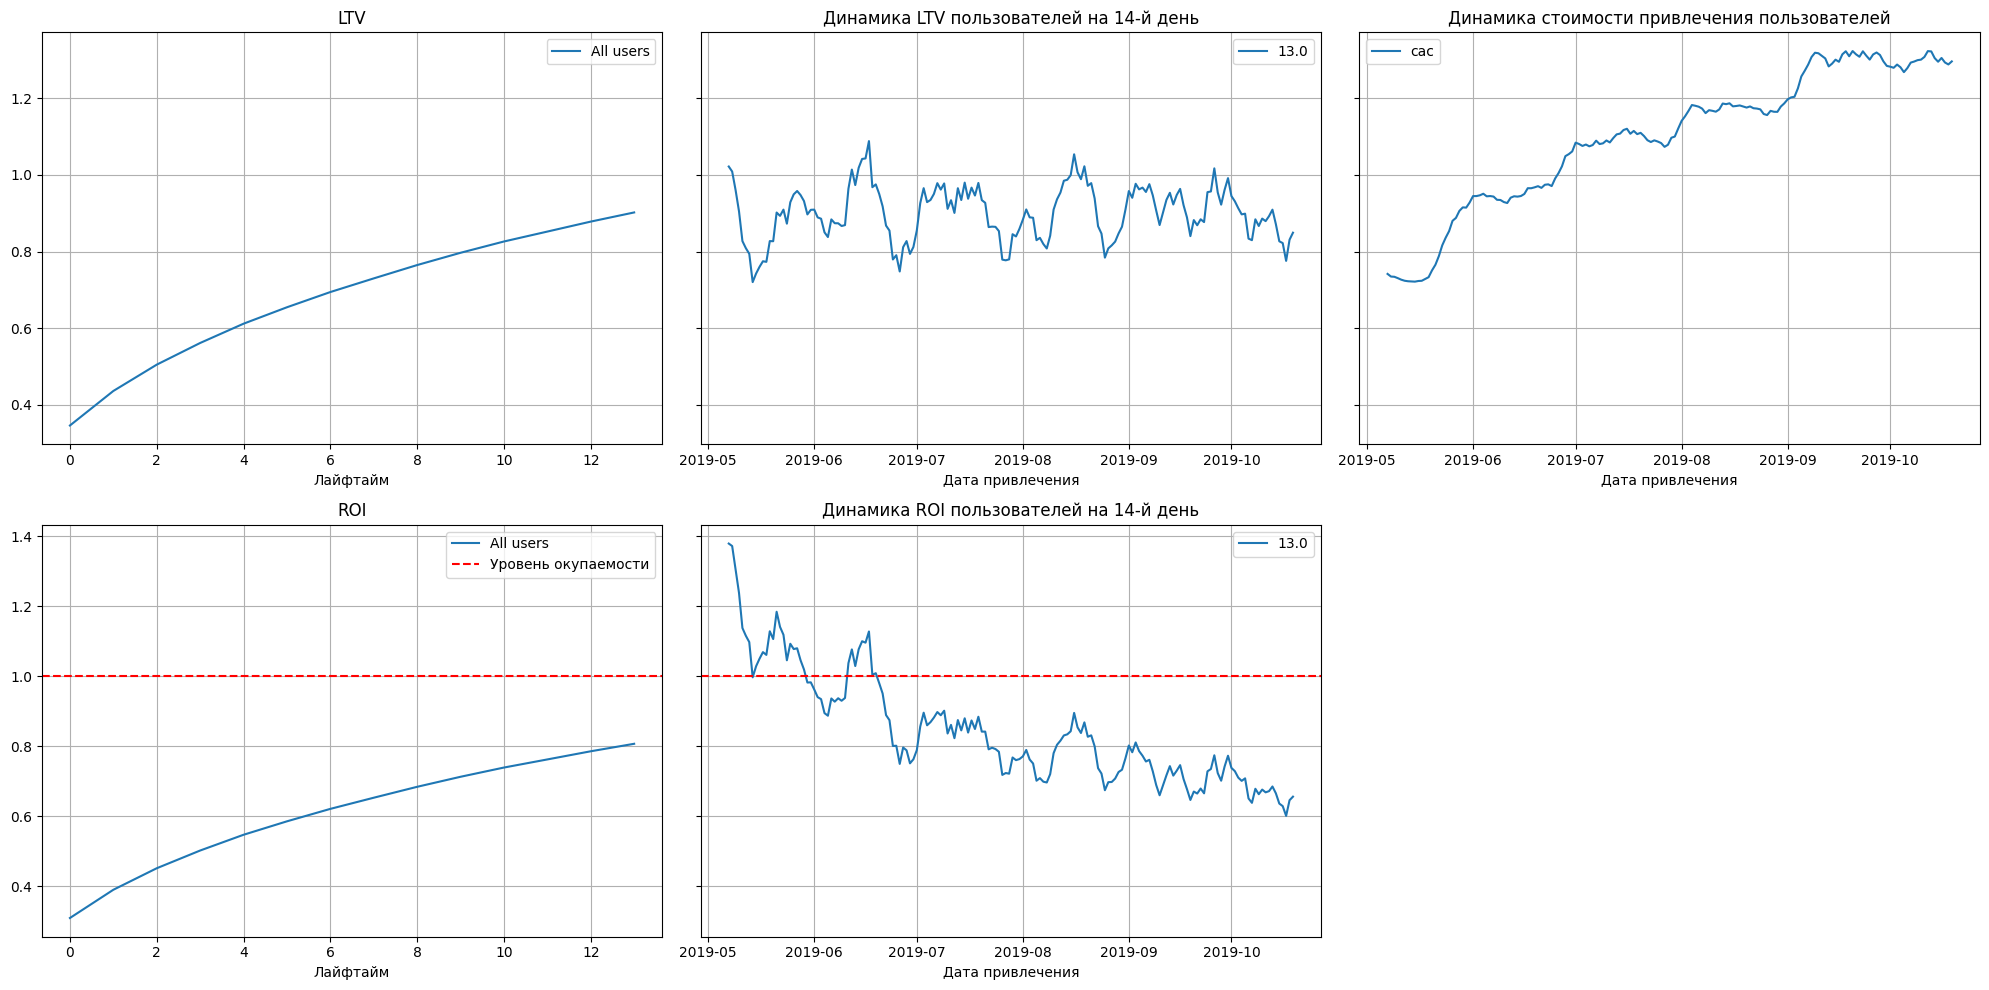

In [59]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:

1) LTV на протяжении первых двух недель растет. На графике динамики LTV мы видим, что средние показатели LTV оставались примерно одинаковыми на все временном промежутке с мая по октябрь

2) Мы видим бурный рост расходов на рекламу на всем периоде исследования. Компания по видимому начинает привлекать более дорогие способы привлечения клиентов, так как CAC непрерывно растет. При этом LTV остается неизменным.

3) Реклама не окупается в первые две недели. ROI приближается к уровню 0.8 к концу второй недели.

4) Можно заметить связь между графиком стоимости привлечения пользователей и графиком с  динамикой

5) ПО графику динамики ROI мы видим, что дела у компании идут все хуже и хуже. Если в мае прибыль все-таки превышала расходы, то к концу октября убытки стремительно увеличиваются.

Как мы видим, увеличение рекламного бюджета в мае - июне не приносит компании ожидаемой прибыли. Именно в соедствии проведения рекламной компании Procrastinate Pro начинает терпеть убытки

#### 5.3.2 Конверсия  пользователей и динамика  изменения.

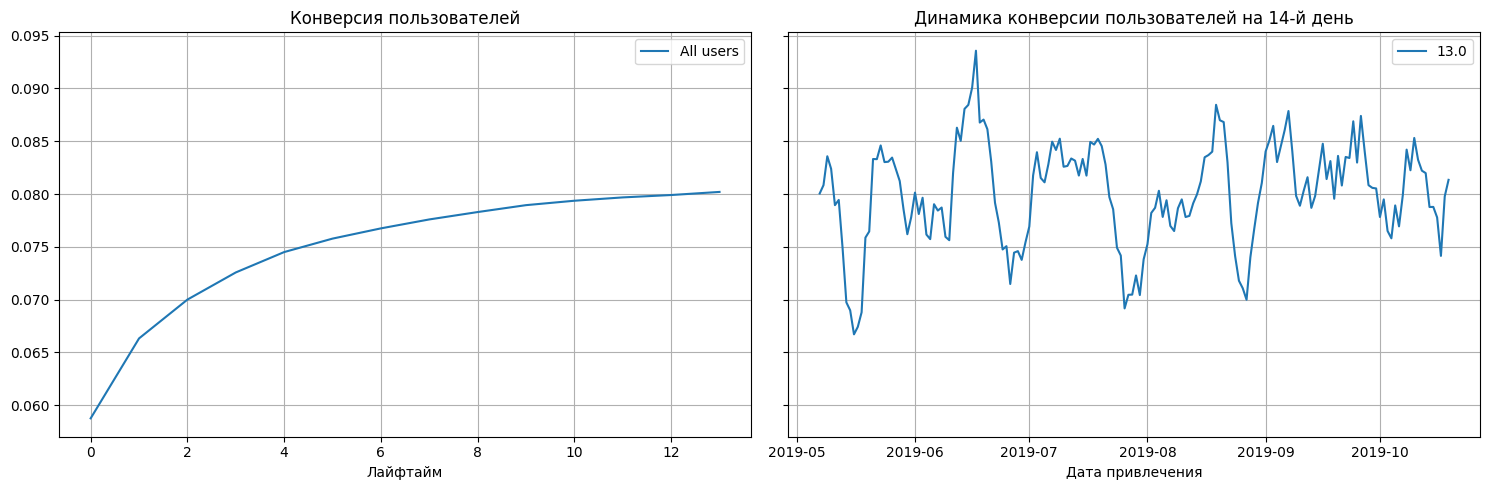

In [63]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    users, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Осовная конверсия происходит в первую неделю наблюдений. При этом показтели конверсии не сильно изменились на всем периоде наблюдений с мая по октябрь

#### 5.3.3 Удержание  пользователей и динамика  изменения.

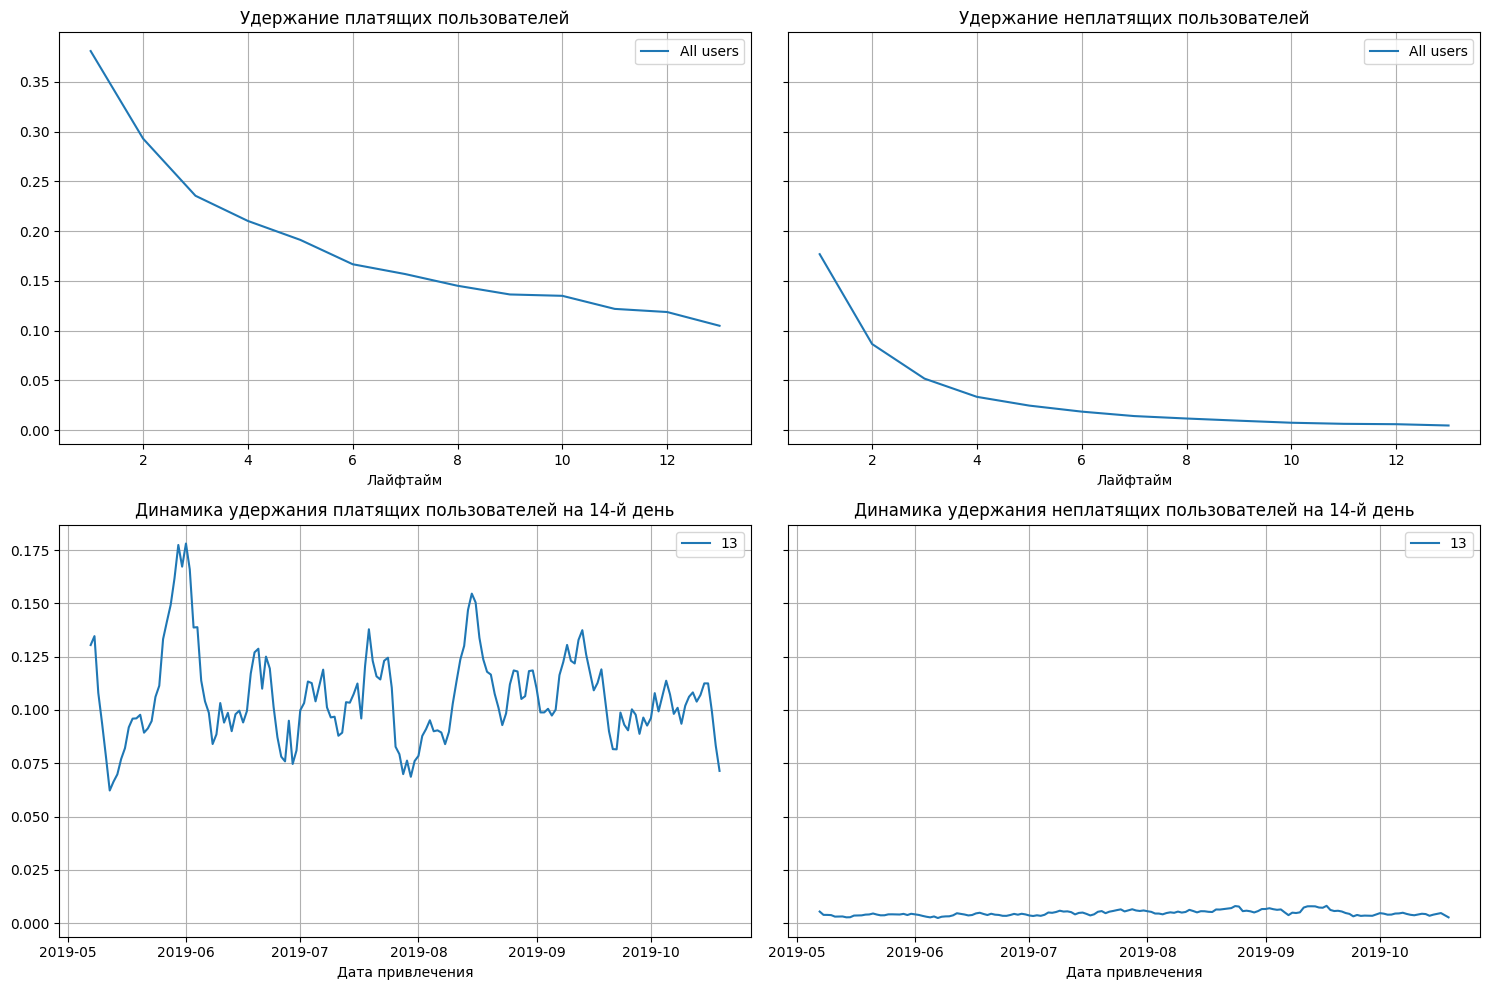

In [64]:
retention_raw, retention_grouped, retention_history = get_retention(
    users, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

Мы видим очень низкие показатели удержания клиентов. График немнго скачкообразный. С мая по июнь мы наблюдаем рост удержания, однако в дальнейшем показатели вернулись к среднему уровню 0.1


#### 5.3.4 LTV и ROI по устройствам

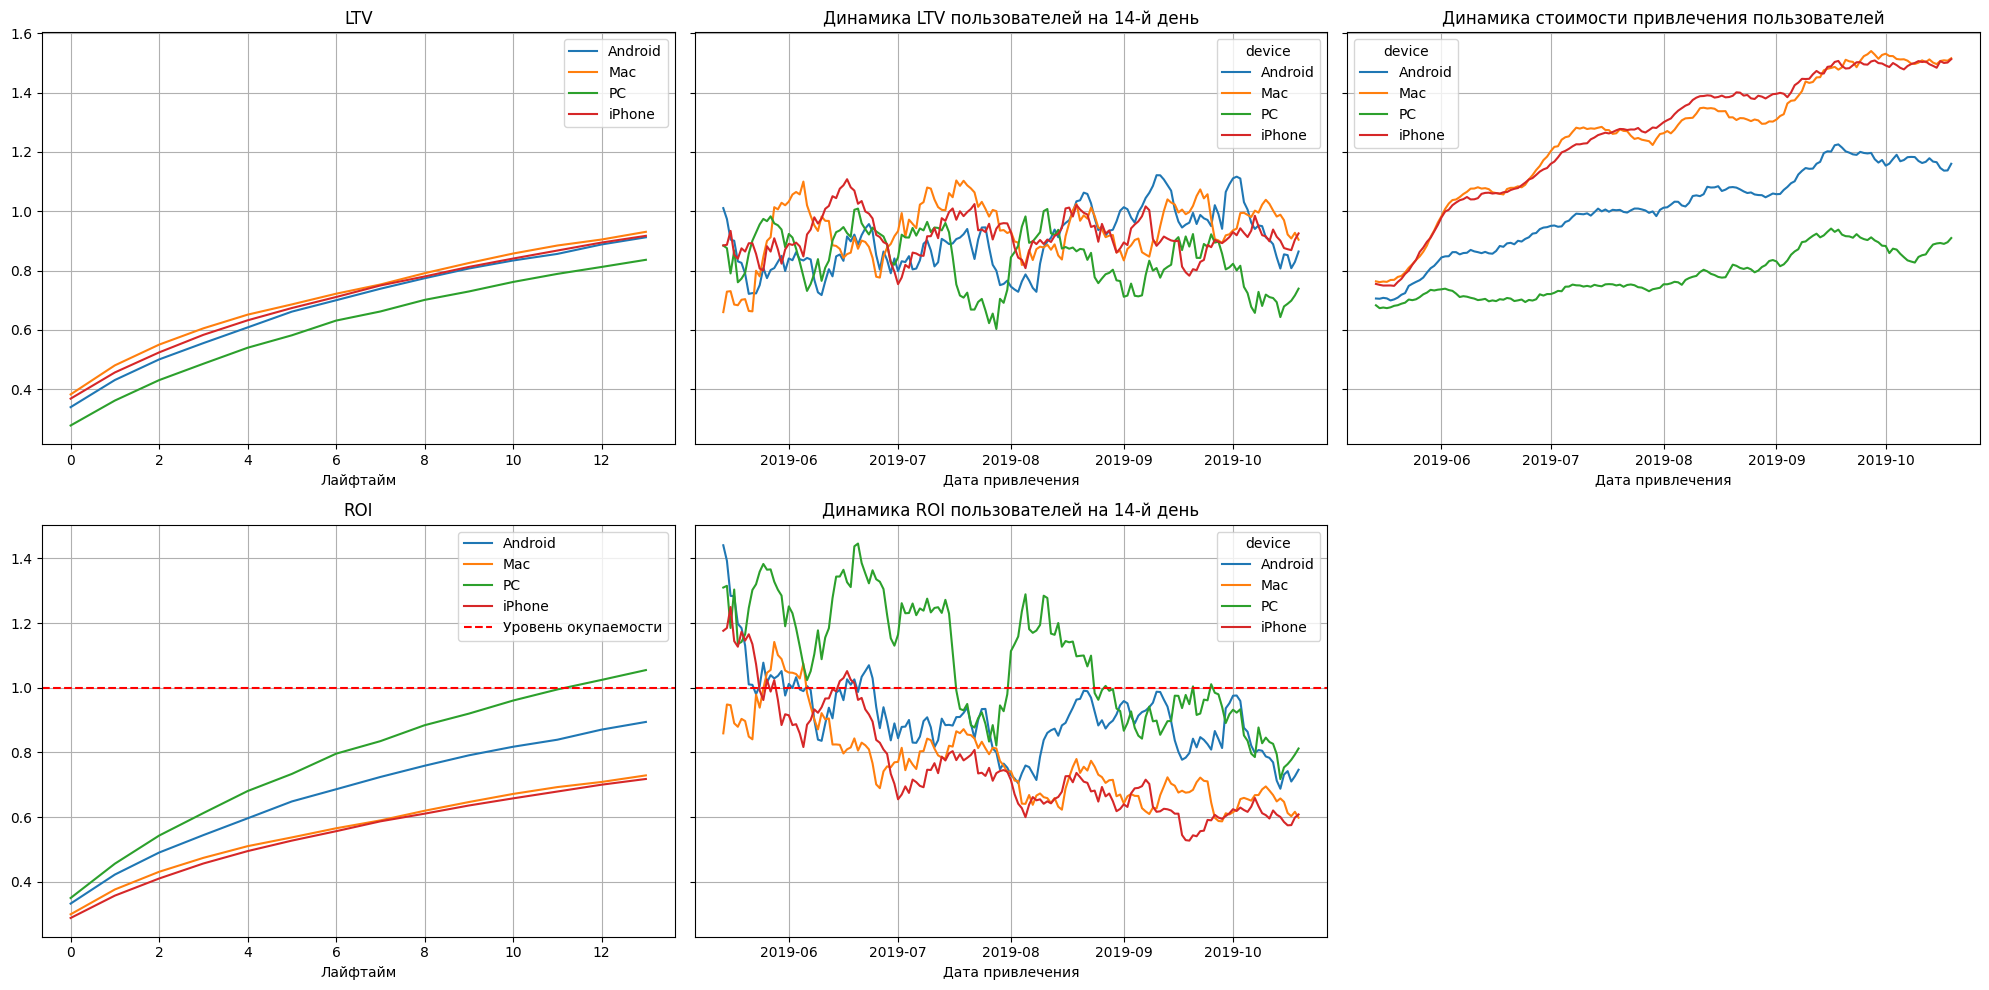

In [65]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    users, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

На графики мы видим, что привлечение пользователей Iphone и Mac стоит дороже, чем пользователей других устройств.
1) CAC у пользователей Iphone и Mac выше, чем у пользователей других устройств.
2) LTV у Iphone, Mac и Android немного выше, чем у пользователей PC
3) ПРи этом только пользователи PC выходят на уровень окупаемостик концу второй недели
4) Динамика ROI неутешительная. В мае пользователи всех устройств, кроме MAC к концу второй недели выходили выше уровня окупаемости, однако к октябрю все устройства
При этом стоимость начинает резко растив середине мая

Чтобы разобраться в причинах финансовых трудностей компании, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

#### 5.3.5 LTV и ROI по странам

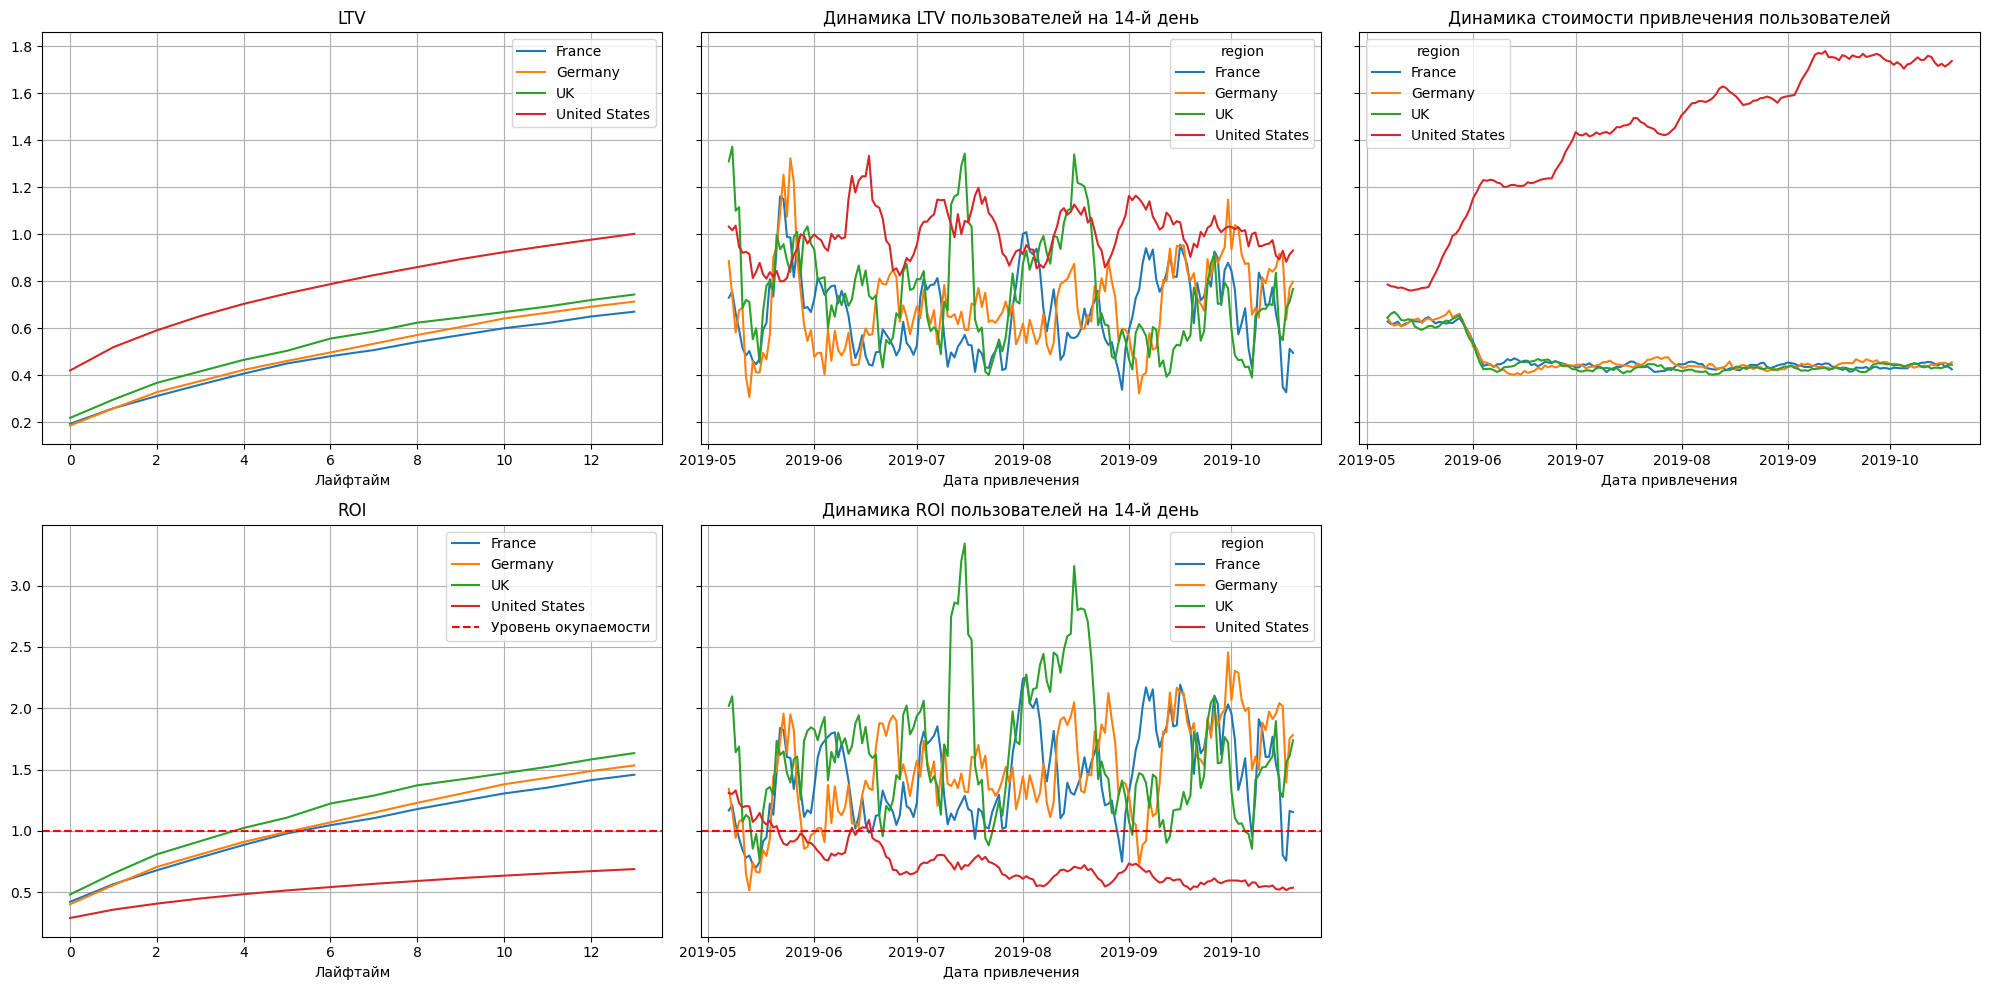

In [67]:
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    users, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

По графикам мы видим, что рекламная компания, которая стартовала в середине мая и существенно увеличиа рекласный бюджет, была нацелена именно на пользователей из США. Пользователи из США действительно показывают хорошую конверсию и составляют более двух третей всех пользователей приложения. Мы также видим, что показатель LTV выше у американцев. Однако, показатели CAC именно у американцев демонстрируют непрерывный рост, в то время как на европейских рынках стоимость привлечения клиента значительно ниже.
За две недели американская аудитория не окупает вложения, показатель Roi очень низкий. Клиенты из других стран - Великобритании, Германии и Франции окупаются уже на 5-6 день пользования приложением.


#### 5.3.6 LTV и ROI по каналам

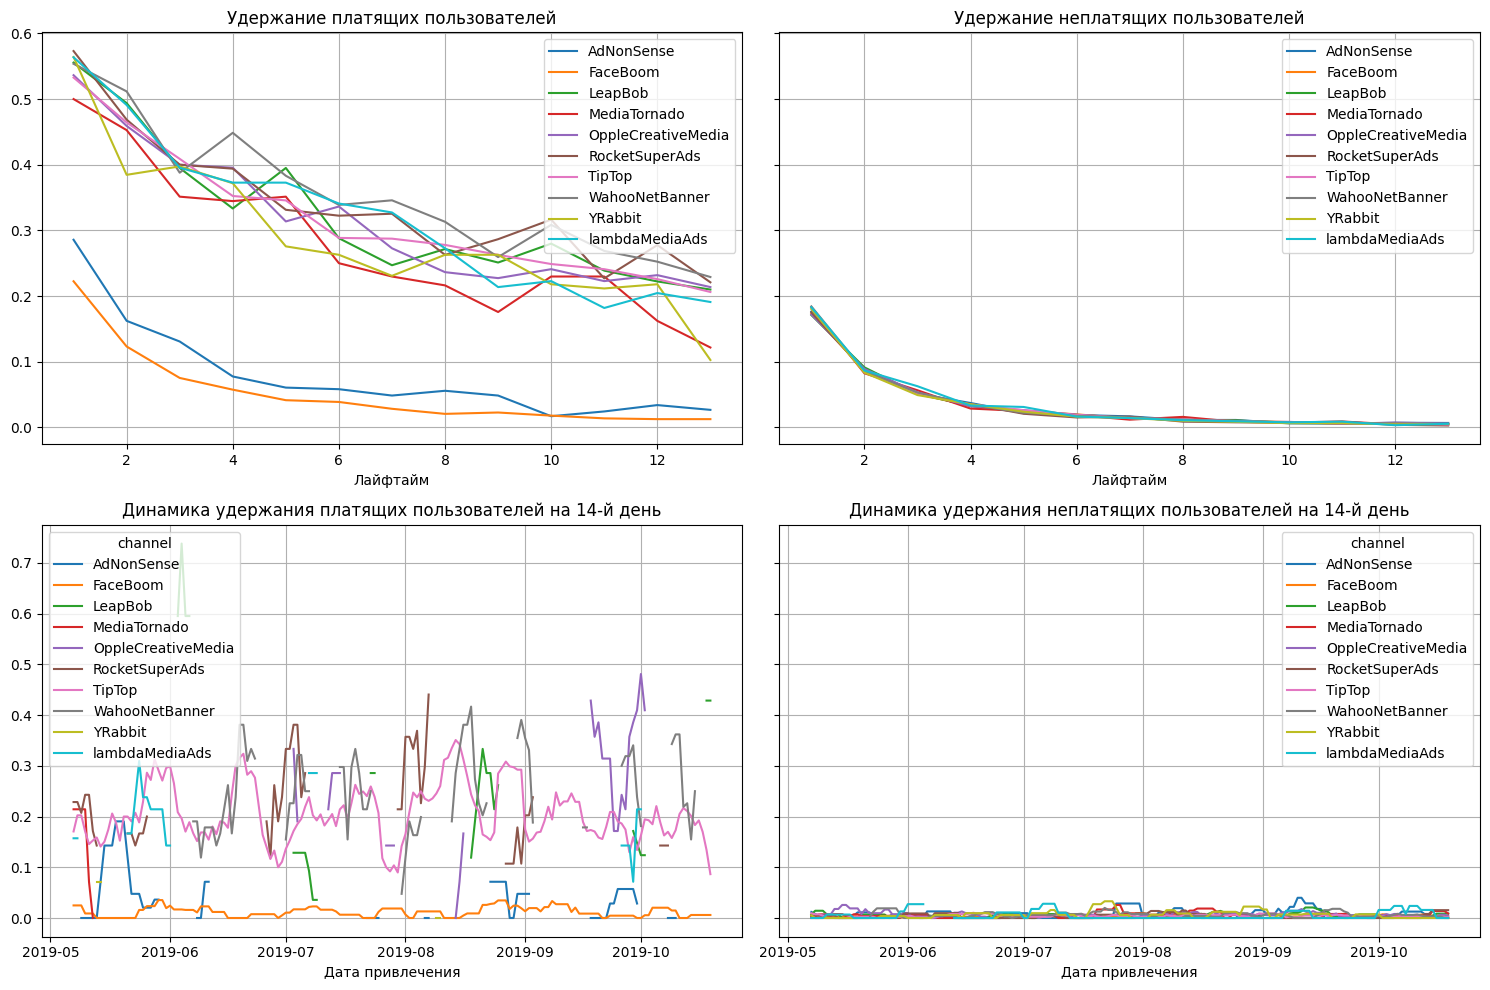

In [68]:
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    users, visits, observation_date, 14, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, 14)

По графикамс разбиением на каналы продвижения мы можем сделать следующие выводы:

1) Самые высокие показтели LTV у каналов TipTop и AdNonSense. Эти показатели остаются самыми высокими на всем периоде наблюдения с мая по октябрь 2) ПРи этом у канала Tip Top, начиная с середины мая, начинает стремительно расти CAC. Посмотрим, окупятся ли такие дорогие клиенты? 3) По графику ROI мы видим, что клиенты с каналов FaceBoom, TipTop и AdNonSense так и не преодолевают порог самоокупаемости по истечению двух недель. Рост LTV у клиентов, пришедьших с TipTop немного компенсирует неудачи, мы не видим динамики падения roi на графике с динамикой ROI. Однако на всем периоде наблюдения порог окупаемости не был преодлен.

Больше всего прибыли приносят компании клиенты с каналов YRabbit (особенно бурный рост был в июле), MediaTornado и LambdaMediaAds. MediaTotando особенно выигрышно смотрится в последние два месяца наблюдений.


Мы не видим существенных различий в удержании пользователей разных устройств. Вероятно, приложение работает примерно одинаково на всех устройствах.

#### 5.3.7 Удержание по каналам

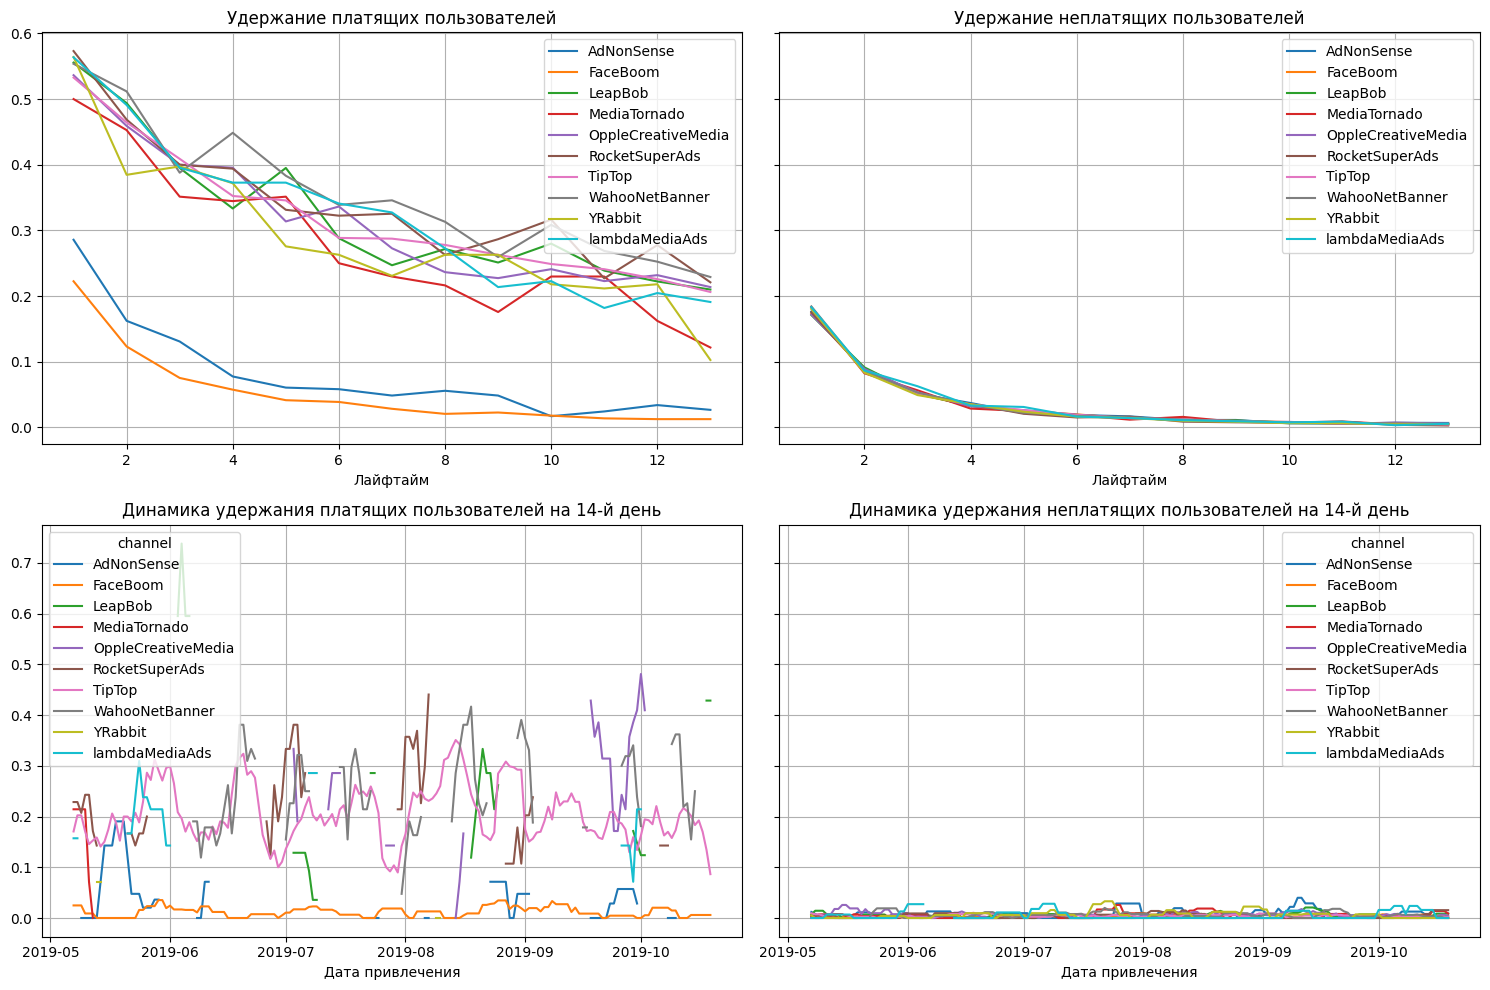

In [69]:
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    users, visits, observation_date, 14, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, 14)

Мы видим, что у клиентов, пришедьших по двум рекламным источникам ('FaceBoom', и 'AdNonSense') очень серьезные проблемы с удержанием. Вероятно, клиенты испытывают разочарование, не получив набор услуг, обещанных в рекламе. Мы уже ранее предлагали не использовать оба источника для привлечения клиентов.

#### 5.3.8 Удержание по устройству

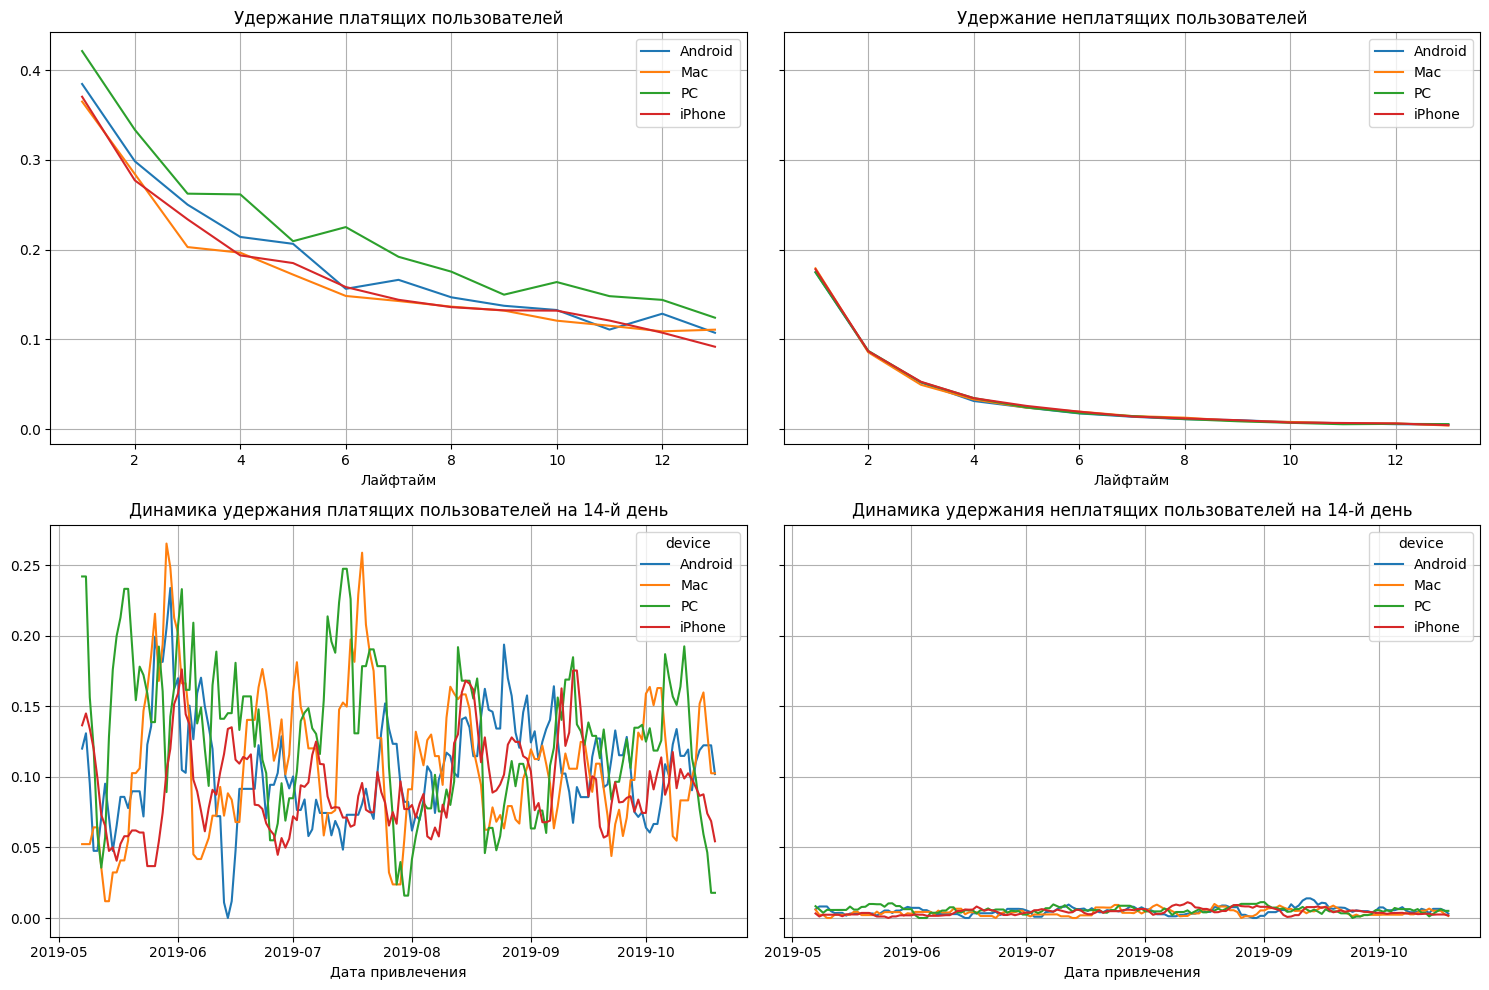

In [70]:
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    users, visits, observation_date, 14, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, 14)

Мы не видим существенных различий в удержании пользователей разных устройств. Вероятно, приложение работает примерно одинаково на всех устройствах.

#### 5.3.9 Удержание по региону

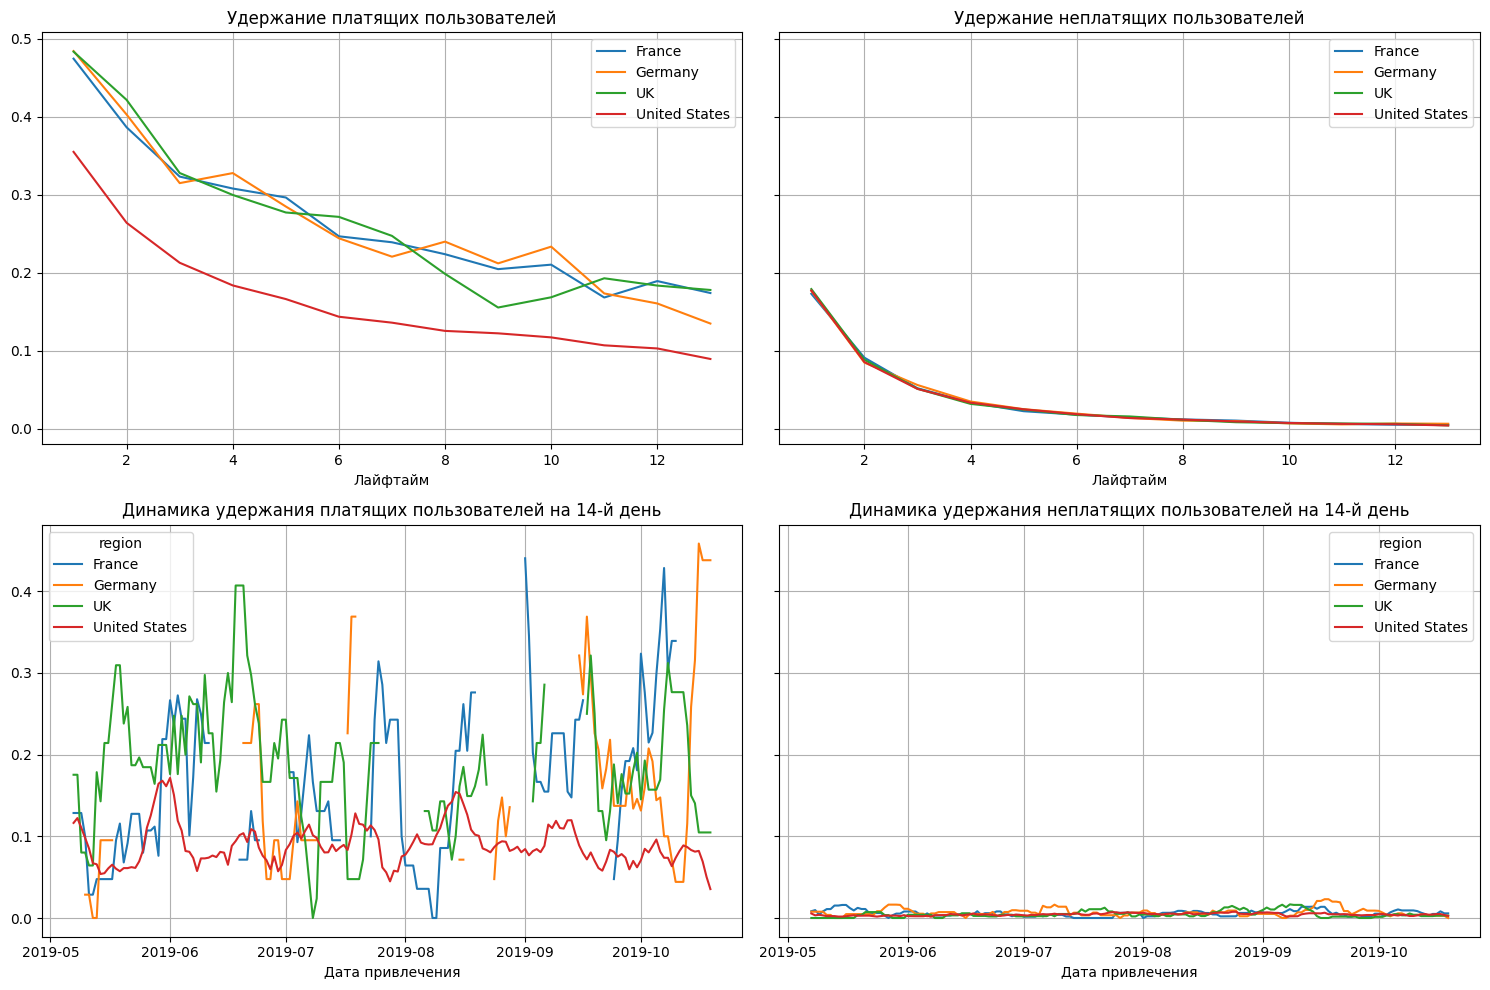

In [71]:
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    users, visits, observation_date, 14, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, 14)

Клиенты из США удерживаются хуже остальных. Одна из возможных причин - несовпадение ожиданий, сформировавшихся от рекламы и действительности.

Попробуем исключить три убыточных канала - FaceBoom, TipTop и AdNonSense. Посмотрим, как будет чувствовать себя бизнес компании, используя другие каналы продвижения

#### 5.3.10 LTV и ROI по срезу данных без убыточных рекламных каналов

In [75]:
chanl = ['FaceBoom', 'TipTop', 'AdNonSense']
users_c1 = users.query('channel not in @chanl')

In [76]:
print(f" Всего клиентов у компании {len(users['user_id'].unique())} ")
print(f" Клиентов, которые не пришли по убыточным каналам {len(users_c1['user_id'].unique())} ")

 Всего клиентов у компании 93569 
 Клиентов, которые не пришли по убыточным каналам 40984 


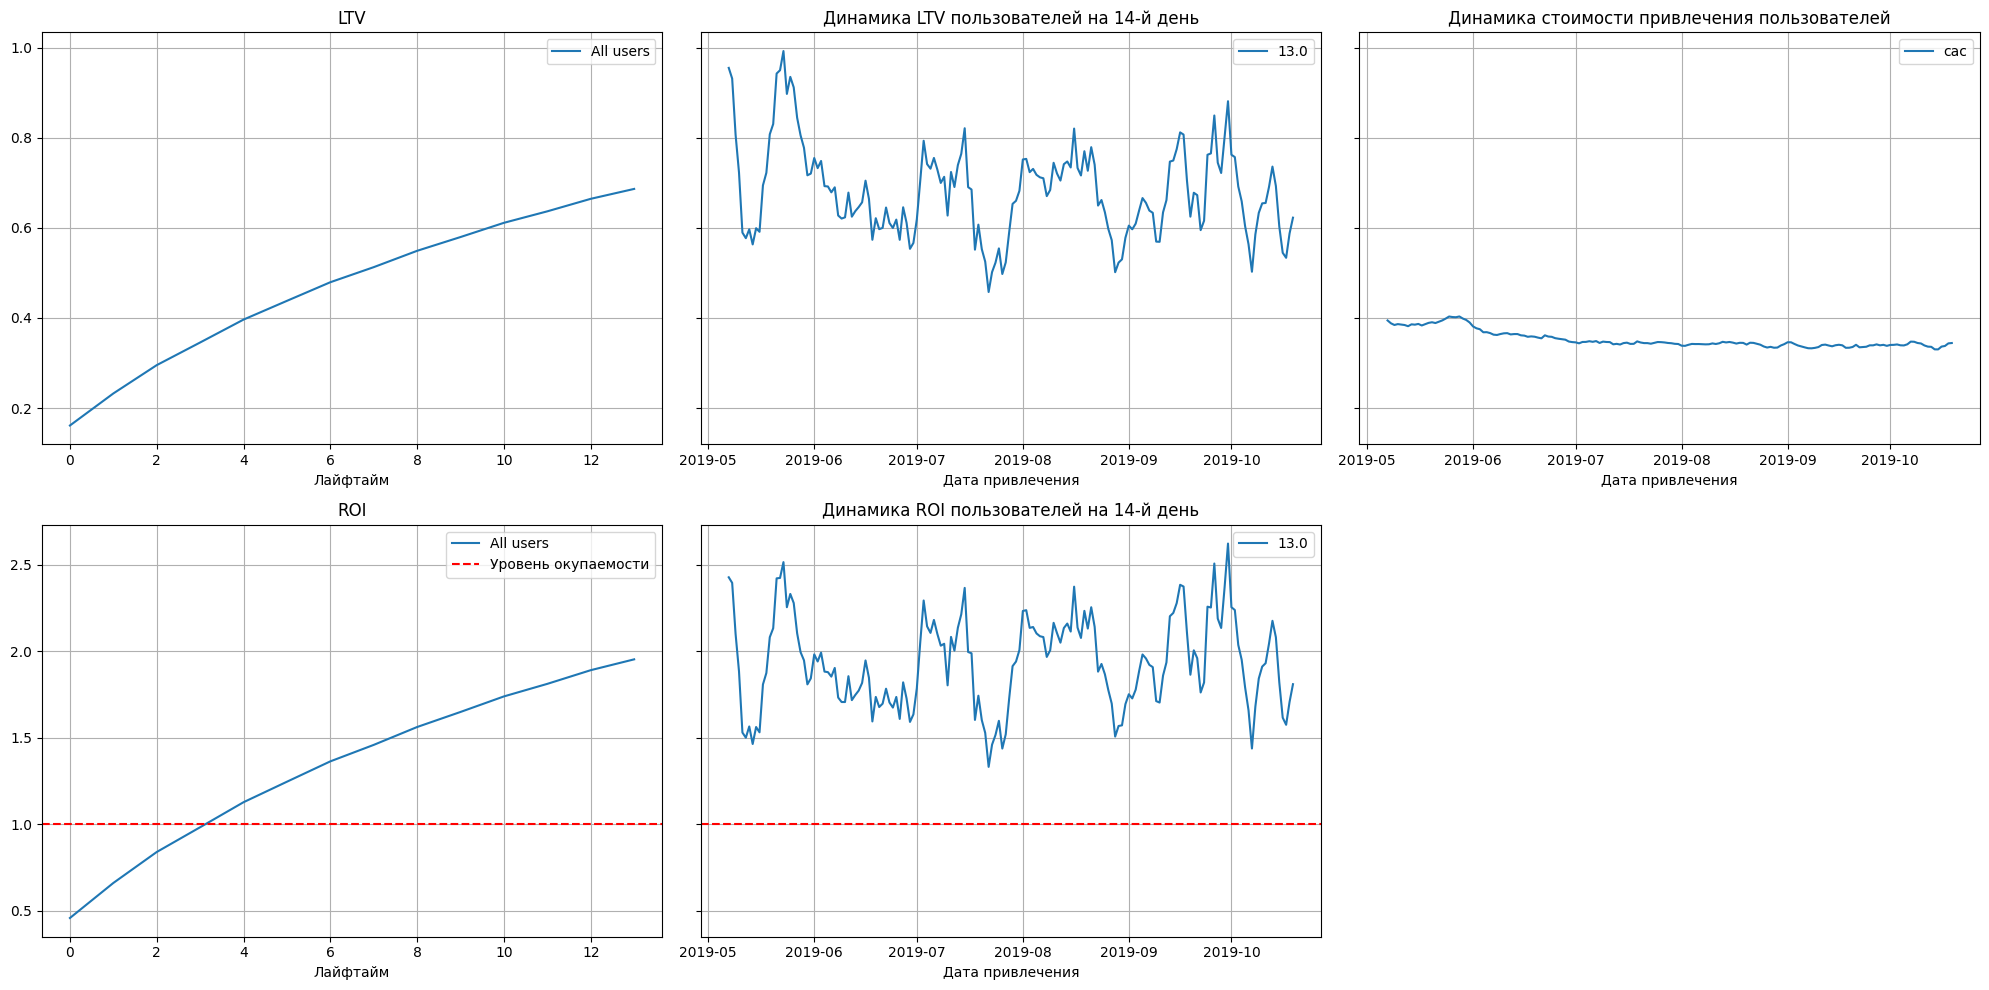

In [74]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    users_c1, orders, observation_date, horizon_days
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Мы исключили три рекламных канала, которые приносили компании больше клиентов, но которые расходовали слишком много рекламного бюджета. В результате количество клиентов уменьшилось на треть, но бизнес в целом чувствует себя прекрасно! Показатель CAC перестал расти, а клиенты окупаются уже на чесвертый день пользования сервисом

##  Результаты исследования


В результате маркетингового исследования мы зафиксировали значительный рост рекламного бюджета, начиная с мая 2019 года. Однако графики возврата инвестиций показывают, что вложения в рекламу не окупились.


Клиенты, пришедшие по платной рекламе, показали очень хорошие показатели по конверсии. Однако, мы наблюдаем бурный рост CAC на всем периоде наблюдения. По-видимому, рекламные каналы тратят все больше средств на привлечение клентов, а клиенты не окупают расходов.


Мы также видим, что мобильному приложению труднее развиваться на американском рынке. Стоимость привлечения клиентов слишком высока, чтобы бизнес окупался. Однако большая часть клиентов приложения - американцы. Мы наблюдаем очень хорошие показатели конверсии, и при этом очень низкие показатели удержания. Мы не заметили явных проблем у пользователей тех или иных устройств, следовательно, проблемы с удержанием американцев следует искать в другой плоскости.

Мы рекомендуем компании исключить три канала продвижения - "FaceBoom", "TipTop" и "AdNonSense". Эти каналы расходуют неоправданно большие средства, которые не окупаются приходящими клиентами.

Мы видим, что у клиентов, привлеченных с помощью двух рекламных источников ("FaceBoom" и "AdNonSense"), возникают серьезные проблемы с удержанием. Вероятно, клиенты испытывают разочарование, не получив набор услуг, обещанных в рекламе. Канал TipTop, показывающий вполне достойные показатели конверсии, по непонятным причинам единственный демонстрирует стремительный рос CAC. Следует найти причины столь активного роста стоимости привлечения клиентов.


Мы видим, что мобильное приложение Procrastinate Pro+ сможет успешно продвигать себя как на американском, так и на европейском рынках, если исключить из рекламного бюджета расходы на рекламу в "FaceBoom", "TipTop" и "AdNonSense". Мы бы рекомендовали больше средств тратить на продвижение по наиболее успешным каналам - YRabbit, MediaTornado и LambdaMediaAds. .